In [47]:
import os
import pandas as pd
import torch
from PIL import Image
import numpy as np

from transformers import CLIPProcessor, CLIPModel, AutoProcessor
from sklearn.metrics.pairwise import cosine_similarity

# from collections import defaultdict
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics.pairwise import cosine_similarity
# import matplotlib.pyplot as plt
# import matplotlib.patches as P
# from tqdm import tqdm
# import csv
# import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
# Load CLIP model and processor
model_name = "openai/clip-vit-large-patch14"
processor = AutoProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

# Embed Dataset

In [35]:
def get_image_embeddings(images):
    inputs = processor(images=images, return_tensors="pt", padding=True)
    inputs = inputs.to(device)
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs['pixel_values']) # Get the class token embedding 
    return image_features  

In [39]:
def compute_image_embeddings(dataset_name='CLEVR', batch_size=100):
    """Computes image embeddings, centers, and normalizes them."""
    metadata = pd.read_csv(f'Data/{dataset_name}/metadata.csv')
    image_paths = metadata['image_path'].tolist()

    # Load images
    print("Loading images...")
    images = []
    for image_filename in tqdm(image_paths):
        #image_path = os.path.join(image_dir, image_filename)
        image = Image.open(image_filename).convert("RGB")
        image_tensor = torch.tensor(np.array(image).transpose((2, 0, 1)))  # Convert image to (C, H, W)
        images.append(image_tensor)
    
    print(f"Loaded {len(images)} images.")

    # Embed images in batches
    print("Computing embeddings in batches...")
    embeddings = []
    n_batches = (len(images) + batch_size - 1) // batch_size  # Calculate number of batches
    for i in tqdm(range(n_batches)):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        batch_embeddings = get_image_embeddings(batch_images)  # Replace with your actual embedding function
        embeddings.append(batch_embeddings)
    
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Concatenate all batch embeddings
    print(f"Extracted embeddings of shape: {embeddings.shape}")

    # Center embeddings
    print("Centering embeddings...")
    mean_embedding = embeddings.mean(dim=0)
    centered_embeddings = embeddings - mean_embedding
    
    # Normalize embeddings
    norm_embeddings = centered_embeddings / centered_embeddings.norm(dim=0, keepdim=True)

    # Save results
    output_file = f'Experiments/Embeddings/{dataset_name}/embeddings.pt'
    torch.save(norm_embeddings, output_file)
    print(f"Embeddings saved to {output_file} :)")

compute_image_embeddings()

Loading images...


100%|██████████| 1001/1001 [00:14<00:00, 68.78it/s]


Loaded 1001 images.
Computing embeddings in batches...


100%|██████████| 11/11 [00:11<00:00,  1.07s/it]

Extracted embeddings of shape: torch.Size([1001, 768])
Centering embeddings...
Embeddings saved to Experiments/Embeddings/CLEVR/embeddings.pt :)


# Compute Concepts

In [58]:
def compute_concepts(dataset_name='CLEVR'):
    """ Computes concept vectors for each concept and saves in a file
    """
    output_dir = f'Experiments/Concepts/{dataset_name}'

    # Load the embeddings and metadata
    embeddings = torch.load(f'Experiments/Embeddings/{dataset_name}/embeddings.pt')  
    metadata_df = pd.read_csv(f'Data/{dataset_name}/metadata.csv')

    # Infer concepts from DataFrame (exclude 'image_path')
    concept_columns = [col for col in metadata_df.columns if col != 'image_path']
    print(f"Inferred concept columns: {concept_columns}")
    
    # Dictionary to store all concept embeddings (merged across all concepts)
    all_concept_embeddings = {}

    # Iterate through each concept column
    for concept in concept_columns:
        
        # Create a dictionary to store the embeddings for each concept value (e.g., 'red', 'blue', etc.)
        concept_embeddings = {}

        # Iterate through each image, its embedding, and the corresponding concept value
        for idx, embedding in enumerate(embeddings):
            concept_value = metadata_df.loc[idx, concept]
            
            # Add the embedding to the dictionary under the concept value
            if concept_value not in concept_embeddings:
                concept_embeddings[concept_value] = []
            concept_embeddings[concept_value].append(embedding)

        # Calculate the average embedding for each concept value
        for value, group_embeddings in concept_embeddings.items():
            group_embeddings = torch.stack(group_embeddings)  # Convert to tensor
            avg_embedding = group_embeddings.mean(dim=0)  # Calculate the average embedding
            avg_embedding = avg_embedding / avg_embedding.norm()  # Normalize the average embedding
            
            # Use a unique identifier for the concept value (combine concept name and value)
            key = f'{concept}_{value}'  # Example: 'color_red' or 'shape_cube'
            all_concept_embeddings[key] = avg_embedding

    # Save **all concept embeddings** in a single file
    output_file = os.path.join(output_dir, 'concepts.pt')
    torch.save(all_concept_embeddings, output_file)
    print(f"All concept embeddings saved at {output_file} :)")

# Example usage:
compute_concepts()

Inferred concept columns: ['color', 'shape', 'size', 'material']
All concept embeddings saved at Experiments/Concepts/CLEVR/concepts.pt :)


# Visualize Concepts

In [69]:
def compute_cosine_sims(dataset_name='CLEVR'):
    """ Compute cosine similarity between each image embeddings and each concept.
    """
    # Load the image and concept embeddings
    embeddings = torch.load(f'Experiments/Embeddings/{dataset_name}/embeddings.pt') 
    all_concept_embeddings = torch.load(f'Experiments/Concepts/{dataset_name}/concepts.pt')

    # Compute cosine similarity for all concept-image pairs
    cosine_similarity_rows = []
    for idx, embedding in enumerate(embeddings):
        cosine_similarity_row = {}

        for concept_value, concept_embedding in all_concept_embeddings.items():
            cosine_sim = cosine_similarity([embedding.numpy()], [concept_embedding.numpy()])[0][0]
            cosine_similarity_row[concept_value] = cosine_sim
        
        cosine_similarity_rows.append(cosine_similarity_row)

    # Create a DataFrame where each column corresponds to a concept-value combination
    cosine_similarity_df = pd.DataFrame(cosine_similarity_rows)
    output_file = f'Experiments/Cosine_Similarities/{dataset_name}/cosine_similarities.csv'
    cosine_similarity_df.to_csv(output_file, index=False)

    print(f"Cosine similarity results for all concepts saved at {output_file} :)")

# Example usage:
compute_cosine_sims()

Cosine similarity results for all concepts saved at Experiments/Cosine_Similarities/CLEVR/cosine_similarities.csv :)


Available concepts to choose from:
1. color_green
2. color_blue
3. color_red
4. shape_cylinder
5. shape_sphere
6. shape_cube
7. size_large
8. material_rubber


Enter the number of the concept you want to sort by (1-8):  5


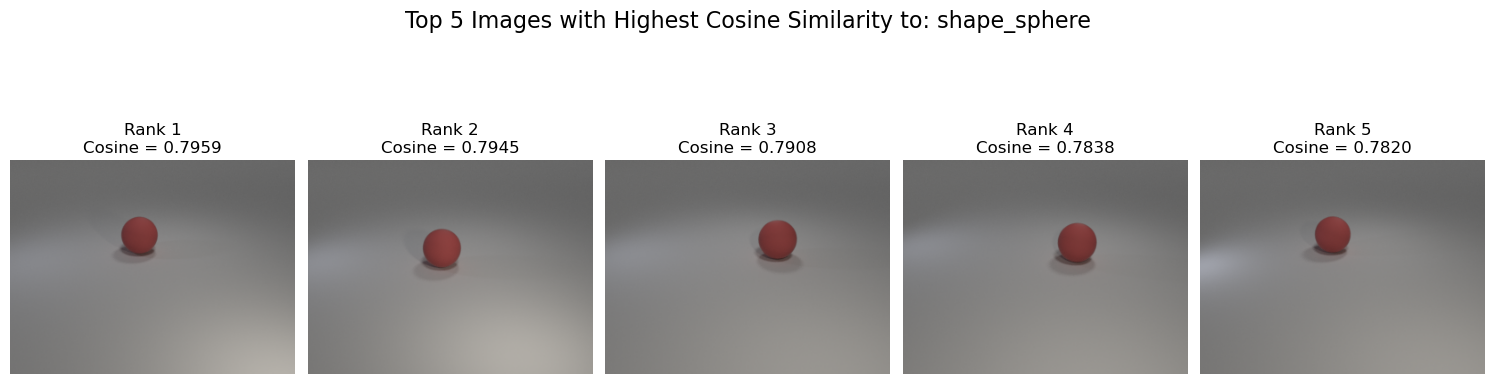

In [88]:
def get_user_choice(concept_columns):
    """Helper function to get the user's choice for concept"""
    print("Available concepts to choose from:")
    for idx, concept in enumerate(concept_columns):
        print(f"{idx + 1}. {concept}")
    
    while True:
        try:
            choice = int(input(f"Enter the number of the concept you want to sort by (1-{len(concept_columns)}): "))
            if 1 <= choice <= len(concept_columns):
                return concept_columns[choice - 1]
            else:
                print("Invalid choice, please select a number from the list.")
        except ValueError:
            print("Invalid input. Please enter a number.")
            
def plot_aligned_images(k=5, dataset_name='CLEVR'):
    """ Plot k images most aligned with a user chosen concept from the given dataset
    """
    
    # Load the cosine similarity results
    cosine_df = pd.read_csv(f'Experiments/Cosine_Similarities/{dataset_name}/cosine_similarities.csv')
    
    # # Get the user's choice of concept out of the potential options
    concept_columns = list(cosine_df.columns)
    concept_key = get_user_choice(concept_columns)
    
    # Sort by cosine similarity and get the top k highest values for the specified concept
    top_k_indices = cosine_df.nlargest(k, concept_key).index.tolist()
    
    # Load metadata
    metadata_df = pd.read_csv(f'Data/{dataset_name}/metadata.csv')
    
    # Calculate the number of rows and columns for the plot
    n_cols = min(k, 5)  # Up to 5 images per row
    n_rows = (k + 4) // 5  # Calculate number of rows needed

    # Plot the top k images based on cosine similarity
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes array to easily index it

    plt.suptitle(f"Top {k} Images with Highest Cosine Similarity to: {concept_key}", fontsize=16)
    
    image_dir = f'Data/{dataset_name}/images/'
    for rank, idx in enumerate(top_k_indices):
        if rank >= len(axes):  # In case there are fewer images than axes
            break
        
        # Get the image path from metadata
        image_filename = metadata_df.loc[idx, 'image_path']
        img = Image.open(image_filename).convert("RGB")

        cos_value = cosine_df.loc[idx, concept_key]
        axes[rank].imshow(img)
        axes[rank].set_title(f"Rank {rank+1}\nCosine = {cos_value:.4f}")
        axes[rank].axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.3) 
    plt.tight_layout(pad=0.9, h_pad=0.2)
    plt.show()


plot_aligned_images()